# EDA for stress levels


In [51]:
#%pip install statsmodels

In [52]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
garmin_base_dir = "../files/Garmin_20241403"

## 22 json files into one dataframe of health data + remove data from before 2020 (no watch)

In [53]:
# Setting up paths and configurations
garmin_base_dir = "../files/Garmin_20241403"
di_connect_path = os.path.join(garmin_base_dir, "DI_CONNECT", "DI-Connect-Aggregator")
columns_of_interest = ['calendarDate', 'totalKilocalories', 'activeKilocalories', 'restingCaloriesFromActivity', 
                       'totalSteps', 'moderateIntensityMinutes', 'vigorousIntensityMinutes', 'userIntensityMinutesGoal', 
                       'minHeartRate', 'maxHeartRate', 'restingHeartRate', 'minAvgHeartRate', 'maxAvgHeartRate',
                       'allDayStress', 'bodyBattery']

# Function to load JSONs and combine them into a filtered DataFrame
def load_and_filter_json(path, start_year=2020):
    all_dfs = []
    for root, _, files in os.walk(path):
        json_files = [f for f in sorted(files) if f.startswith('UDS') and f.endswith('.json')]
        for file in json_files:
            with open(os.path.join(root, file), 'r') as f:
                data = json.load(f)
            df = pd.DataFrame(data) if isinstance(data, list) else pd.DataFrame([data])
            all_dfs.append(df)

    # Combining and filtering the data
    if all_dfs:
        full_df = pd.concat(all_dfs, ignore_index=True)
        full_df['calendarDate'] = pd.to_datetime(full_df['calendarDate'])
        filtered_df = full_df.loc[full_df['calendarDate'].dt.year >= start_year, columns_of_interest]
        return filtered_df
    return pd.DataFrame()  # Return empty DataFrame if no data was loaded

# Apply the function and display the resulting DataFrame
focus_df = load_and_filter_json(di_connect_path)
focus_df.head()


,calendarDate,totalKilocalories,activeKilocalories,restingCaloriesFromActivity,totalSteps,moderateIntensityMinutes,vigorousIntensityMinutes,userIntensityMinutesGoal,minHeartRate,maxHeartRate,restingHeartRate,minAvgHeartRate,maxAvgHeartRate,allDayStress,bodyBattery
14,2020-06-18,1923.0,446.0,NaN,13987.0,11.0,0.0,180.0,64.0,128.0,68.0,65.0,121.0,"{'userProfilePK': 86607424, 'calendarDate': '2...","{'userProfilePK': 86607424, 'calendarDate': '2..."
15,2020-06-19,1885.0,408.0,NaN,12455.0,2.0,10.0,180.0,55.0,160.0,64.0,56.0,158.0,"{'userProfilePK': 86607424, 'calendarDate': '2...","{'userProfilePK': 86607424, 'calendarDate': '2..."
16,2020-06-20,2456.0,975.0,NaN,26379.0,20.0,88.0,180.0,53.0,159.0,62.0,54.0,156.0,"{'userProfilePK': 86607424, 'calendarDate': '2...","{'userProfilePK': 86607424, 'calendarDate': '2..."
17,2020-06-21,2202.0,734.0,NaN,12401.0,52.0,4.0,180.0,50.0,139.0,60.0,52.0,134.0,"{'userProfilePK': 86607424, 'calendarDate': '2...","{'userProfilePK': 86607424, 'calendarDate': '2..."
18,2020-06-22,2017.0,549.0,NaN,15256.0,5.0,43.0,180.0,53.0,152.0,60.0,54.0,149.0,"{'userProfilePK': 86607424, 'calendarDate': '2...","{'userProfilePK': 86607424, 'calendarDate': '2..."


## restingHeartRate, minAvgHeartRate	and maxAvgHeartRate as 	

### restingHeartRate

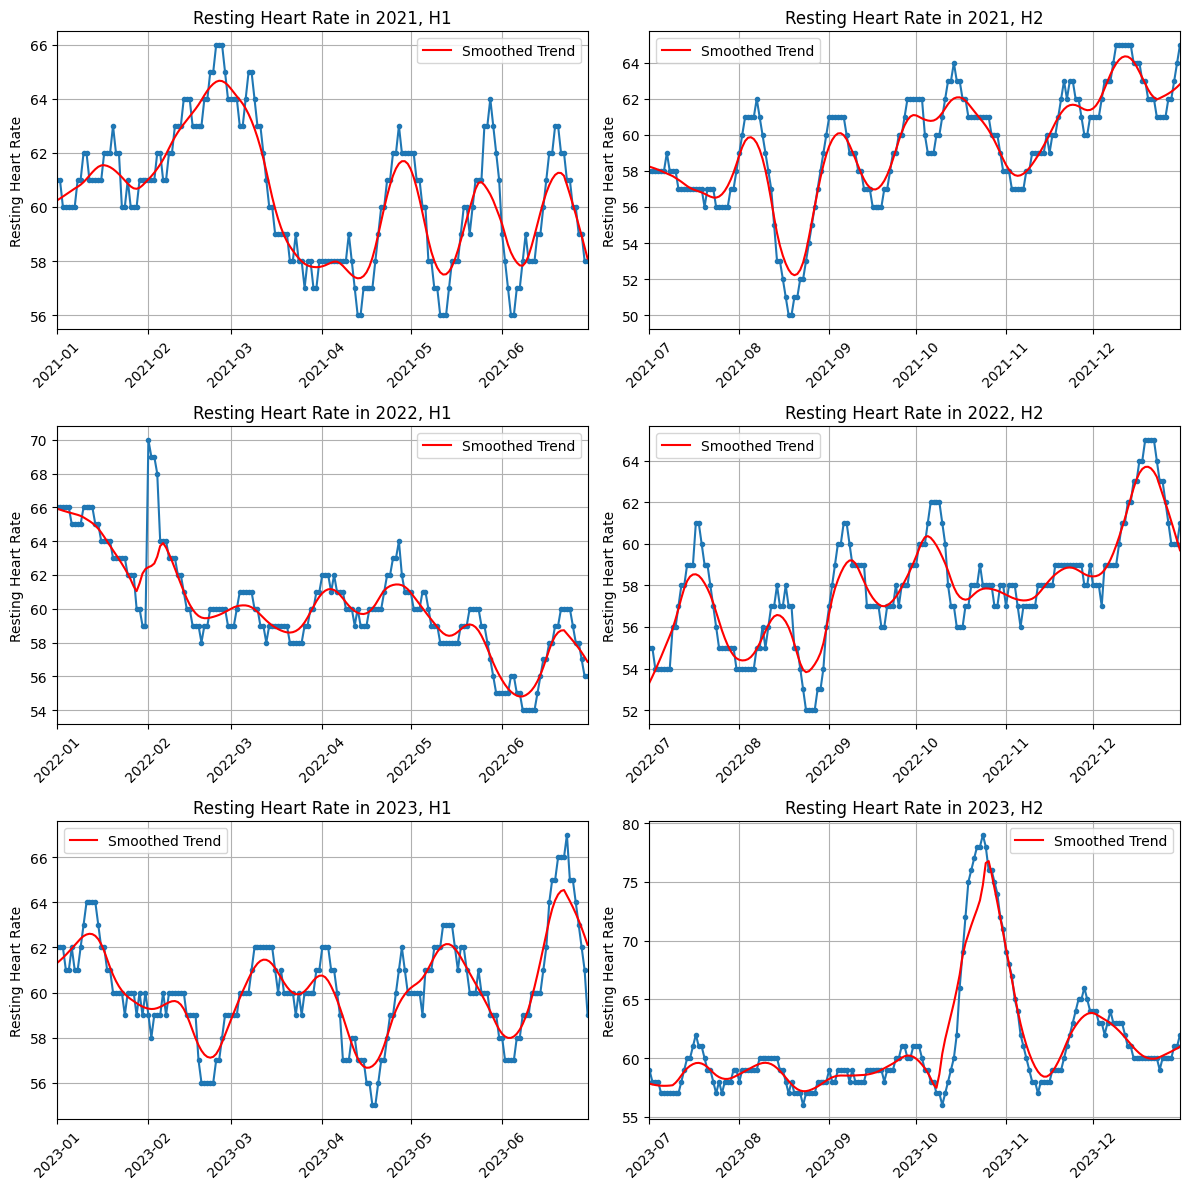

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

# Assuming 'calendarDate' and 'AverageStressLevel' are in your DataFrame
focus_df['calendarDate'] = pd.to_datetime(focus_df['calendarDate'])  # Ensure this column is datetime if not already

#only the years of 2021-2023
focus_df = focus_df[focus_df['calendarDate'] >= '2021-01-01']  
focus_df = focus_df[focus_df['calendarDate'] <= '2023-12-31']  

focus_df['year'] = focus_df['calendarDate'].dt.year  # Extract year from date for grouping
focus_df['half'] = (focus_df['calendarDate'].dt.month - 1) // 6 + 1  # Determine the half of the year

# Prepare subplots
years = focus_df['year'].unique()
years.sort()
halfs = [1, 2]  # Two halves in a year
fig, axes = plt.subplots(nrows=len(years), ncols=2, figsize=(12, 4 * len(years)))  # One row per year, two columns for each half
axes = axes.ravel()

plot_index = 0
for year in years:
    for half in halfs:
        ax = axes[plot_index]
        half_data = focus_df[(focus_df['year'] == year) & (focus_df['half'] == half)]

        if half_data.empty:
            ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f"No Data in {year}, H{half}")
            ax.set_xlim([pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31')])
        else:
            # Plot raw data as a line plot
            ax.plot(half_data['calendarDate'], half_data['restingHeartRate'], marker='.', linestyle='-')
            
            # Ensure that the calendarDate is converted to numeric for lowess smoothing
            numeric_dates = mdates.date2num(half_data['calendarDate'])
            
            # Lowess smoothing
            smoothed = lowess(half_data['restingHeartRate'], numeric_dates, frac=0.1)
            ax.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], 'r-', label='Smoothed Trend')
            
            ax.set_title(f"Resting Heart Rate in {year}, H{half}")
            ax.set_ylabel('Resting Heart Rate')
            ax.grid(True)
            
            # Set x-axis major locator to month starts and formatter to year-month format
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            
            # Set x-axis limits based on the half
            if half == 1:
                ax.set_xlim([pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-06-30')])
            else:
                ax.set_xlim([pd.Timestamp(f'{year}-07-01'), pd.Timestamp(f'{year}-12-31')])

            # Rotate date labels
            plt.setp(ax.get_xticklabels(), rotation=45)

            ax.legend()
        
        plot_index += 1

plt.tight_layout()
plt.show()


**Same but in one plot**

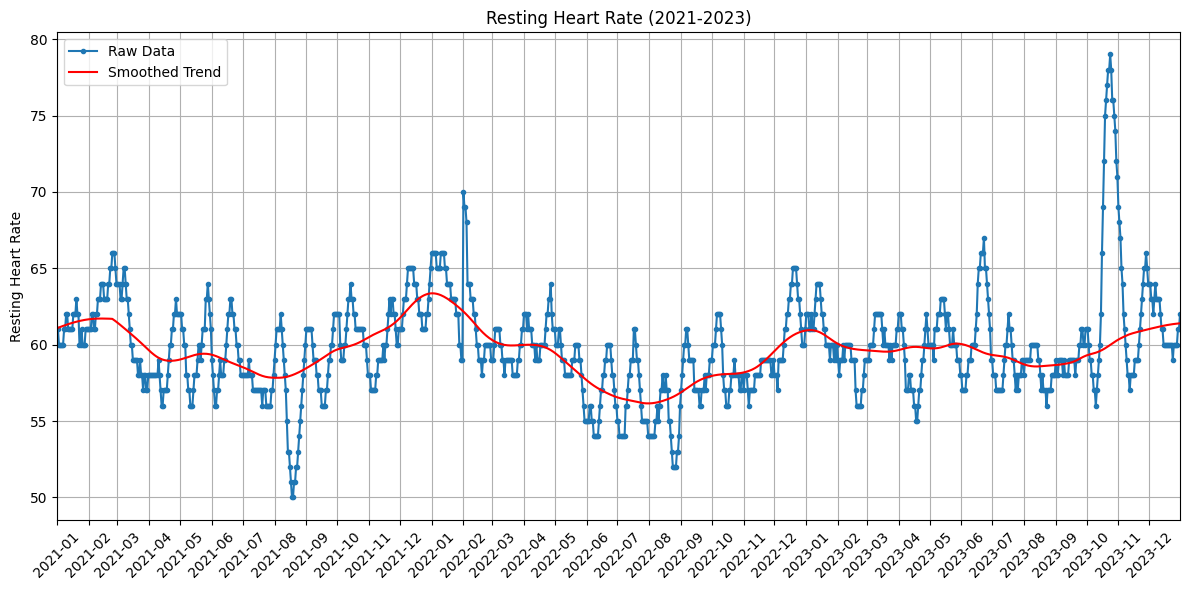

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

# Assuming 'calendarDate' and 'AverageStressLevel' are in your DataFrame
focus_df['calendarDate'] = pd.to_datetime(focus_df['calendarDate'])  # Ensure this column is datetime if not already

# Filter only the years of 2021-2023
focus_df = focus_df[(focus_df['calendarDate'] >= '2021-01-01') & (focus_df['calendarDate'] <= '2023-12-31')]

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot raw data
ax.plot(focus_df['calendarDate'], focus_df['restingHeartRate'], marker='.', linestyle='-', label='Raw Data')

# Convert dates to numeric values for LOWESS smoothing
numeric_dates = mdates.date2num(focus_df['calendarDate'])

# LOWESS smoothing
smoothed = lowess(focus_df['restingHeartRate'], numeric_dates, frac=0.1)
ax.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], 'r-', label='Smoothed Trend')

# Set plot title and labels
ax.set_title('Resting Heart Rate (2021-2023)')
ax.set_ylabel('Resting Heart Rate')
ax.grid(True)

# Set x-axis major locator to month starts and formatter to year-month format
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim([pd.Timestamp('2021-01-01'), pd.Timestamp('2023-12-31')])

# Rotate date labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45)

ax.legend()

plt.tight_layout()
plt.show()


### minAvgHeartRate

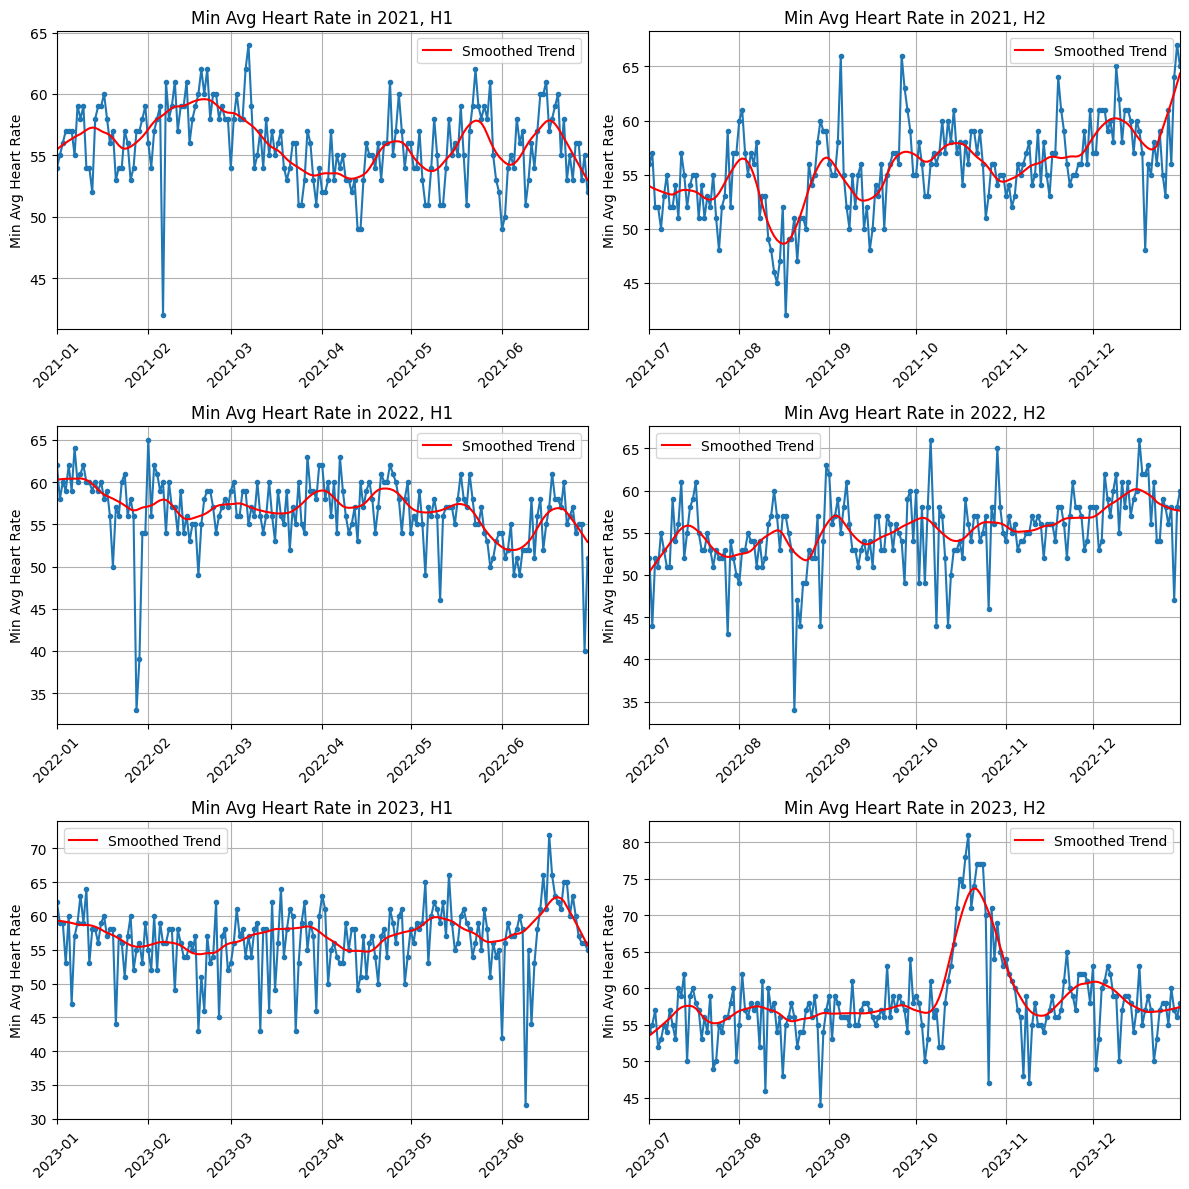

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

# Assuming 'calendarDate' and 'AverageStressLevel' are in your DataFrame
focus_df['calendarDate'] = pd.to_datetime(focus_df['calendarDate'])  # Ensure this column is datetime if not already

#only the years of 2021-2023
focus_df = focus_df[focus_df['calendarDate'] >= '2021-01-01']  
focus_df = focus_df[focus_df['calendarDate'] <= '2023-12-31']  

focus_df['year'] = focus_df['calendarDate'].dt.year  # Extract year from date for grouping
focus_df['half'] = (focus_df['calendarDate'].dt.month - 1) // 6 + 1  # Determine the half of the year

# Prepare subplots
years = focus_df['year'].unique()
years.sort()
halfs = [1, 2]  # Two halves in a year
fig, axes = plt.subplots(nrows=len(years), ncols=2, figsize=(12, 4 * len(years)))  # One row per year, two columns for each half
axes = axes.ravel()

plot_index = 0
for year in years:
    for half in halfs:
        ax = axes[plot_index]
        half_data = focus_df[(focus_df['year'] == year) & (focus_df['half'] == half)]

        if half_data.empty:
            ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f"No Data in {year}, H{half}")
            ax.set_xlim([pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31')])
        else:
            # Plot raw data as a line plot
            ax.plot(half_data['calendarDate'], half_data['minAvgHeartRate'], marker='.', linestyle='-')
            
            # Ensure that the calendarDate is converted to numeric for lowess smoothing
            numeric_dates = mdates.date2num(half_data['calendarDate'])
            
            # Lowess smoothing
            smoothed = lowess(half_data['minAvgHeartRate'], numeric_dates, frac=0.1)
            ax.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], 'r-', label='Smoothed Trend')
            
            ax.set_title(f"Min Avg Heart Rate in {year}, H{half}")
            ax.set_ylabel('Min Avg Heart Rate')
            ax.grid(True)
            
            # Set x-axis major locator to month starts and formatter to year-month format
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            
            # Set x-axis limits based on the half
            if half == 1:
                ax.set_xlim([pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-06-30')])
            else:
                ax.set_xlim([pd.Timestamp(f'{year}-07-01'), pd.Timestamp(f'{year}-12-31')])

            # Rotate date labels
            plt.setp(ax.get_xticklabels(), rotation=45)

            ax.legend()
        
        plot_index += 1

plt.tight_layout()
plt.show()


**Same but in one plot**

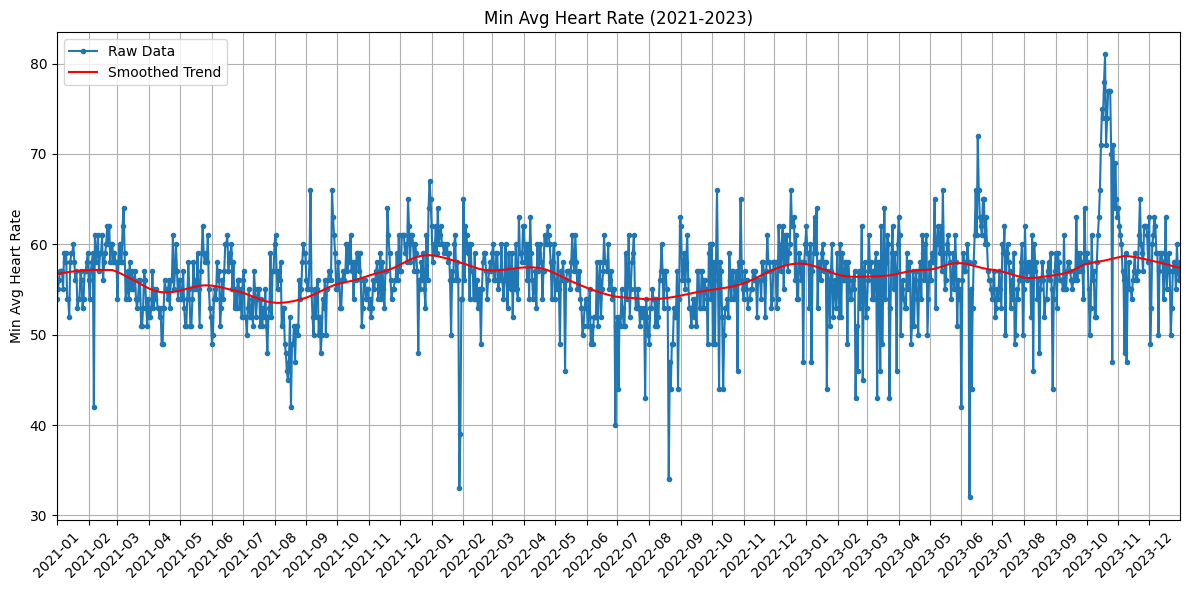

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

# Assuming 'calendarDate' and 'AverageStressLevel' are in your DataFrame
focus_df['calendarDate'] = pd.to_datetime(focus_df['calendarDate'])  # Ensure this column is datetime if not already

# Filter only the years of 2021-2023
focus_df = focus_df[(focus_df['calendarDate'] >= '2021-01-01') & (focus_df['calendarDate'] <= '2023-12-31')]

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot raw data
ax.plot(focus_df['calendarDate'], focus_df['minAvgHeartRate'], marker='.', linestyle='-', label='Raw Data')

# Convert dates to numeric values for LOWESS smoothing
numeric_dates = mdates.date2num(focus_df['calendarDate'])

# LOWESS smoothing
smoothed = lowess(focus_df['minAvgHeartRate'], numeric_dates, frac=0.1)
ax.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], 'r-', label='Smoothed Trend')

# Set plot title and labels
ax.set_title('Min Avg Heart Rate (2021-2023)')
ax.set_ylabel('Min Avg Heart Rate')
ax.grid(True)

# Set x-axis major locator to month starts and formatter to year-month format
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim([pd.Timestamp('2021-01-01'), pd.Timestamp('2023-12-31')])

# Rotate date labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45)

ax.legend()

plt.tight_layout()
plt.show()


### maxAvgHeartRate

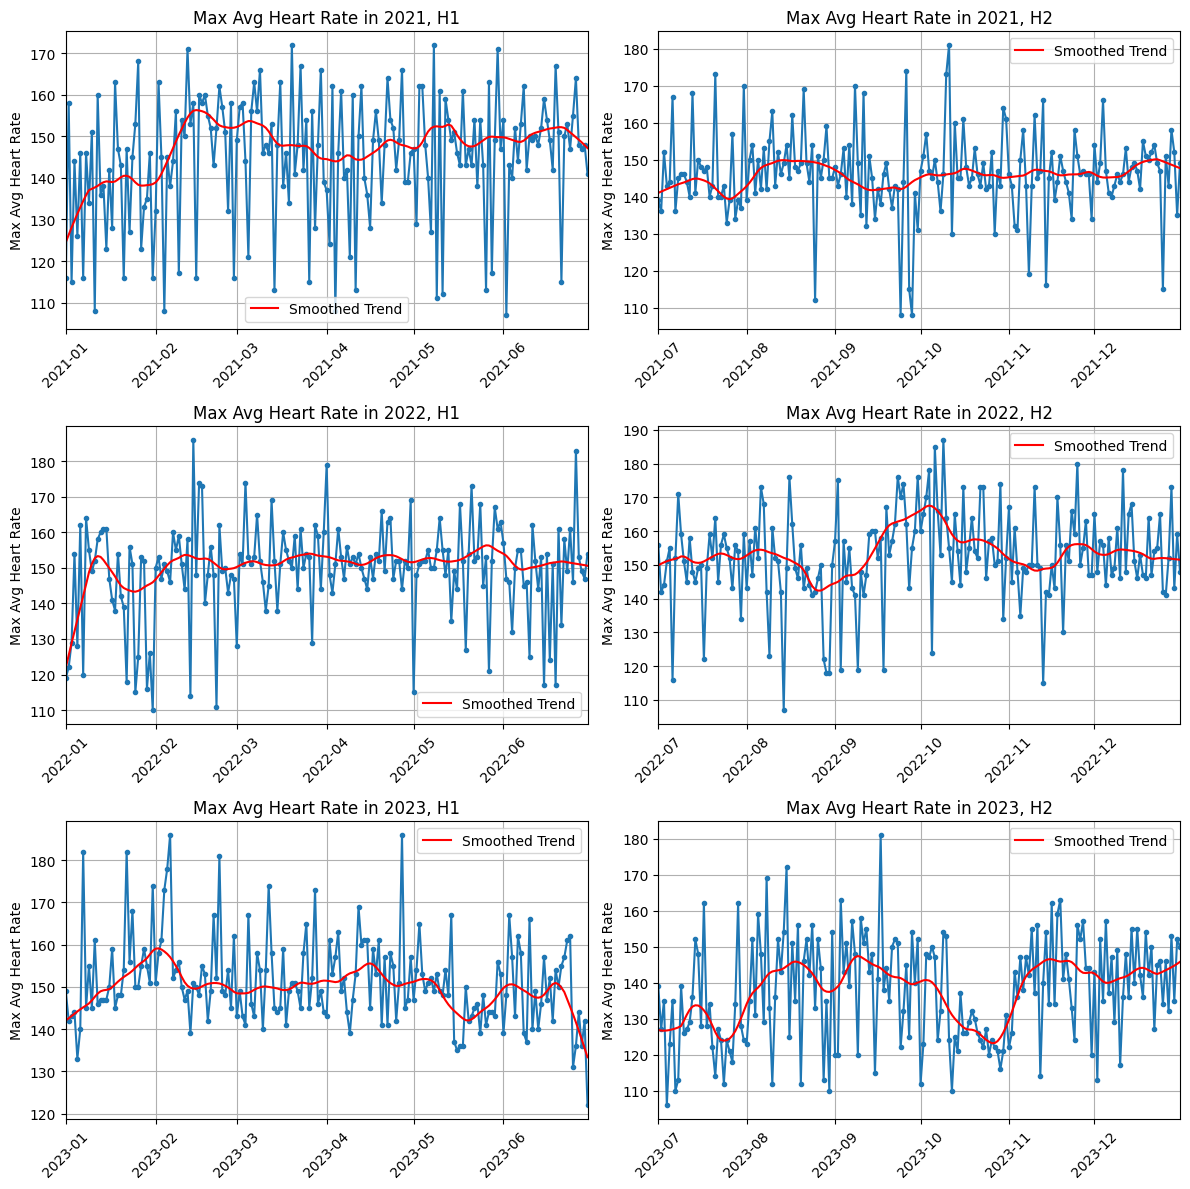

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

# Assuming 'calendarDate' and 'AverageStressLevel' are in your DataFrame
focus_df['calendarDate'] = pd.to_datetime(focus_df['calendarDate'])  # Ensure this column is datetime if not already

#only the years of 2021-2023
focus_df = focus_df[focus_df['calendarDate'] >= '2021-01-01']  
focus_df = focus_df[focus_df['calendarDate'] <= '2023-12-31']  

focus_df['year'] = focus_df['calendarDate'].dt.year  # Extract year from date for grouping
focus_df['half'] = (focus_df['calendarDate'].dt.month - 1) // 6 + 1  # Determine the half of the year

# Prepare subplots
years = focus_df['year'].unique()
years.sort()
halfs = [1, 2]  # Two halves in a year
fig, axes = plt.subplots(nrows=len(years), ncols=2, figsize=(12, 4 * len(years)))  # One row per year, two columns for each half
axes = axes.ravel()

plot_index = 0
for year in years:
    for half in halfs:
        ax = axes[plot_index]
        half_data = focus_df[(focus_df['year'] == year) & (focus_df['half'] == half)]

        if half_data.empty:
            ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f"No Data in {year}, H{half}")
            ax.set_xlim([pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31')])
        else:
            # Plot raw data as a line plot
            ax.plot(half_data['calendarDate'], half_data['maxAvgHeartRate'], marker='.', linestyle='-')
            
            # Ensure that the calendarDate is converted to numeric for lowess smoothing
            numeric_dates = mdates.date2num(half_data['calendarDate'])
            
            # Lowess smoothing
            smoothed = lowess(half_data['maxAvgHeartRate'], numeric_dates, frac=0.1)
            ax.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], 'r-', label='Smoothed Trend')
            
            ax.set_title(f"Max Avg Heart Rate in {year}, H{half}")
            ax.set_ylabel('Max Avg Heart Rate')
            ax.grid(True)
            
            # Set x-axis major locator to month starts and formatter to year-month format
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            
            # Set x-axis limits based on the half
            if half == 1:
                ax.set_xlim([pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-06-30')])
            else:
                ax.set_xlim([pd.Timestamp(f'{year}-07-01'), pd.Timestamp(f'{year}-12-31')])

            # Rotate date labels
            plt.setp(ax.get_xticklabels(), rotation=45)

            ax.legend()
        
        plot_index += 1

plt.tight_layout()
plt.show()


**Same but in one plot**

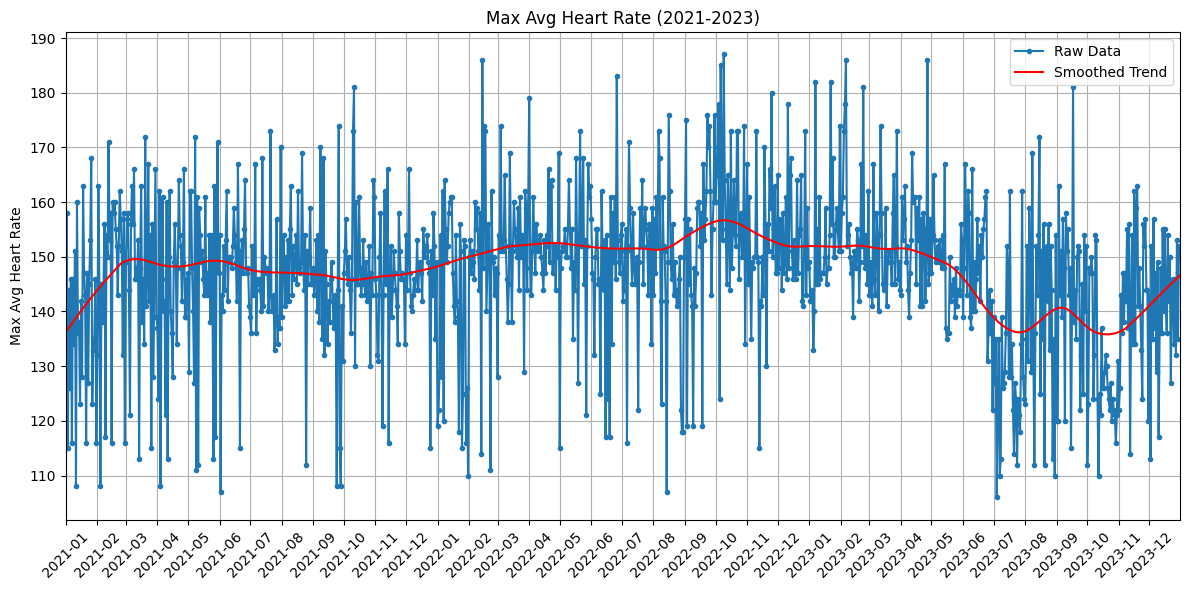

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

# Assuming 'calendarDate' and 'AverageStressLevel' are in your DataFrame
focus_df['calendarDate'] = pd.to_datetime(focus_df['calendarDate'])  # Ensure this column is datetime if not already

# Filter only the years of 2021-2023
focus_df = focus_df[(focus_df['calendarDate'] >= '2021-01-01') & (focus_df['calendarDate'] <= '2023-12-31')]

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot raw data
ax.plot(focus_df['calendarDate'], focus_df['maxAvgHeartRate'], marker='.', linestyle='-', label='Raw Data')

# Convert dates to numeric values for LOWESS smoothing
numeric_dates = mdates.date2num(focus_df['calendarDate'])

# LOWESS smoothing
smoothed = lowess(focus_df['maxAvgHeartRate'], numeric_dates, frac=0.1)
ax.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], 'r-', label='Smoothed Trend')

# Set plot title and labels
ax.set_title('Max Avg Heart Rate (2021-2023)')
ax.set_ylabel('Max Avg Heart Rate')
ax.grid(True)

# Set x-axis major locator to month starts and formatter to year-month format
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim([pd.Timestamp('2021-01-01'), pd.Timestamp('2023-12-31')])

# Rotate date labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45)

ax.legend()

plt.tight_layout()
plt.show()
